# HW 7: K-Fold Cross-Validation
## 2022104346 정지헌

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from typing import Iterable
import pandas as pd

In [2]:
class SeqModel(nn.Module):
    def __init__(self, depth: int, input_dim: int = 1, output_dim: int = 1, hidden_dim: int = 6):
        super().__init__()
        self.layer_list = nn.ModuleList()
        self.layer_list.append(nn.Linear(input_dim, hidden_dim))
        self.layer_list.append(nn.Tanh())

        for _ in range(depth - 1):
            self.layer_list.append(nn.Linear(hidden_dim, hidden_dim))
            self.layer_list.append(nn.Tanh())

        self.layer_list.append(nn.Linear(hidden_dim, output_dim))
    
    def forward(self, x: torch.Tensor):
        for layer in self.layer_list:
            x = layer(x)
        
        return x
    


In [3]:
class NoisySinDataLoader:
    def __init__(self, k: int = 5):
        self.raw_data_shuffled = np.loadtxt('./noisy_sin_sample.csv',delimiter=',',dtype="float32")
        np.random.shuffle(self.raw_data_shuffled)
        
        self.k = k
        self.data_count = self.raw_data_shuffled.shape[0]
        self.validation_data_count = self.data_count // k
        self.training_data_count = self.data_count - self.validation_data_count

        self.x_shuffled = self.raw_data_shuffled[:, 0]
        self.y_shuffled = self.raw_data_shuffled[:, 1]

        self.training_xs = []
        self.training_ys = []

        self.validation_xs = []
        self.validation_ys = []

        for i in range(self.k):
            if i == 0:
                self.validation_xs.append(self.x_shuffled[: self.validation_data_count, np.newaxis])
                self.validation_ys.append(self.y_shuffled[: self.validation_data_count, np.newaxis])
                self.training_xs.append(self.x_shuffled[self.validation_data_count :, np.newaxis])
                self.training_ys.append(self.y_shuffled[self.validation_data_count :, np.newaxis])
            elif i == self.k - 1:
                self.validation_xs.append(self.x_shuffled[i * self.validation_data_count :, np.newaxis])
                self.validation_ys.append(self.y_shuffled[i * self.validation_data_count :, np.newaxis])
                self.training_xs.append(self.x_shuffled[: i * self.validation_data_count, np.newaxis])
                self.training_ys.append(self.y_shuffled[: i * self.validation_data_count, np.newaxis])
            else:
                self.validation_xs.append(self.x_shuffled[i * self.validation_data_count : (i + 1) * self.validation_data_count, np.newaxis])
                self.validation_ys.append(self.y_shuffled[i * self.validation_data_count : (i + 1) * self.validation_data_count, np.newaxis])
                self.training_xs.append(np.concatenate((self.x_shuffled[: i * self.validation_data_count], self.x_shuffled[(i + 1) * self.validation_data_count :]))[:, np.newaxis])
                self.training_ys.append(np.concatenate((self.y_shuffled[: i * self.validation_data_count], self.x_shuffled[(i + 1) * self.validation_data_count :]))[:, np.newaxis])

    def load_training_data(self, fold_num: int):

        return torch.tensor(self.training_xs[fold_num]), torch.tensor(self.training_ys[fold_num])
    
    def load_validation_data(self, fold_num: int):

        return torch.tensor(self.validation_xs[fold_num]), torch.tensor(self.validation_ys[fold_num])
    
    def load_full_data(self):
        return torch.tensor(self.x_shuffled[:, np.newaxis]), torch.tensor(self.y_shuffled[:, np.newaxis])


In [4]:
class KFoldTrainer:
    def __init__(self, data_loader: NoisySinDataLoader, k: int = 5, hidden_dim: int = 6, depths: Iterable[int] = [1, 2, 3, 4], learning_rate: float = 1e-3):
        self.k = k
        self.depths_count = len(depths)
        self.hidden_dim = hidden_dim
        self.depths = depths
        self.data_loader = data_loader
        """ if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu' """
        
        self.models = {"model_%d"%(i): SeqModel(depth = i, hidden_dim = hidden_dim) for i in depths}
        self.optimizers = {"model_%d"%(i): torch.optim.Adam(params = self.models["model_%d"%(i)].parameters(), lr = learning_rate) for i in depths}
        self.cost_functions = {"model_%d"%(i): nn.MSELoss() for i in depths}

        self.cost_results = {"model_%d"%(i): [None for _ in range(self.k)] for i in depths}

    def train(self, fold_num, model_select, iteration_count = 600000):
        x_train_data, y_train_data = self.data_loader.load_training_data(fold_num)

        for _ in range(iteration_count):
            model_output = self.models[model_select].forward(x_train_data)
            cost = self.cost_functions[model_select].forward(model_output, y_train_data)

            cost.backward()
            self.optimizers[model_select].step()
        
        with torch.no_grad():
            x_validation_data, y_validation_data = self.data_loader.load_validation_data(fold_num)
            model_output = self.models[model_select].forward(x_validation_data)
            cost = self.cost_functions[model_select].forward(model_output, y_validation_data)

            self.cost_results[model_select][fold_num] = float(cost)

    def train_all_folds(self, model_select, iteration_count = 600000):
        for i in range(self.k):
            self.train(fold_num = i, model_select= model_select, iteration_count = iteration_count)
            
        self.cost_results[model_select].append(np.mean(self.cost_results[model_select]))

    def train_all_models(self, iteration_count = 600000):
        for i in self.depths:
            self.train_all_folds("model_%d"%(i), iteration_count)
        
        return pd.DataFrame(self.cost_results, index = ["fold %d"%(i) for i in range(self.k)] + ["average"])

In [5]:
data_loader = NoisySinDataLoader(k = 5)
trainer = KFoldTrainer(data_loader = data_loader, k = 5, hidden_dim = 6, depths = [1, 2, 3, 4])

trainer.train_all_models()

KeyboardInterrupt: 

Model 2 is the model with the smallest average cost

Training Model 2 with the full dataset

In [ ]:
final_model = SeqModel(2, 1, 1, 6)
final_optim = torch.optim.Adam(final_model.parameters(), lr = 1e-3)
final_cost_function = nn.MSELoss()

full_x, full_y = data_loader.load_full_data()

for _ in range(300000):
    final_model_output = final_model.forward(full_x)
    final_cost = final_cost_function.forward(final_model_output, full_y)

    final_cost.backward()
    final_optim.step()


visualizing the final model trained with the full dataset

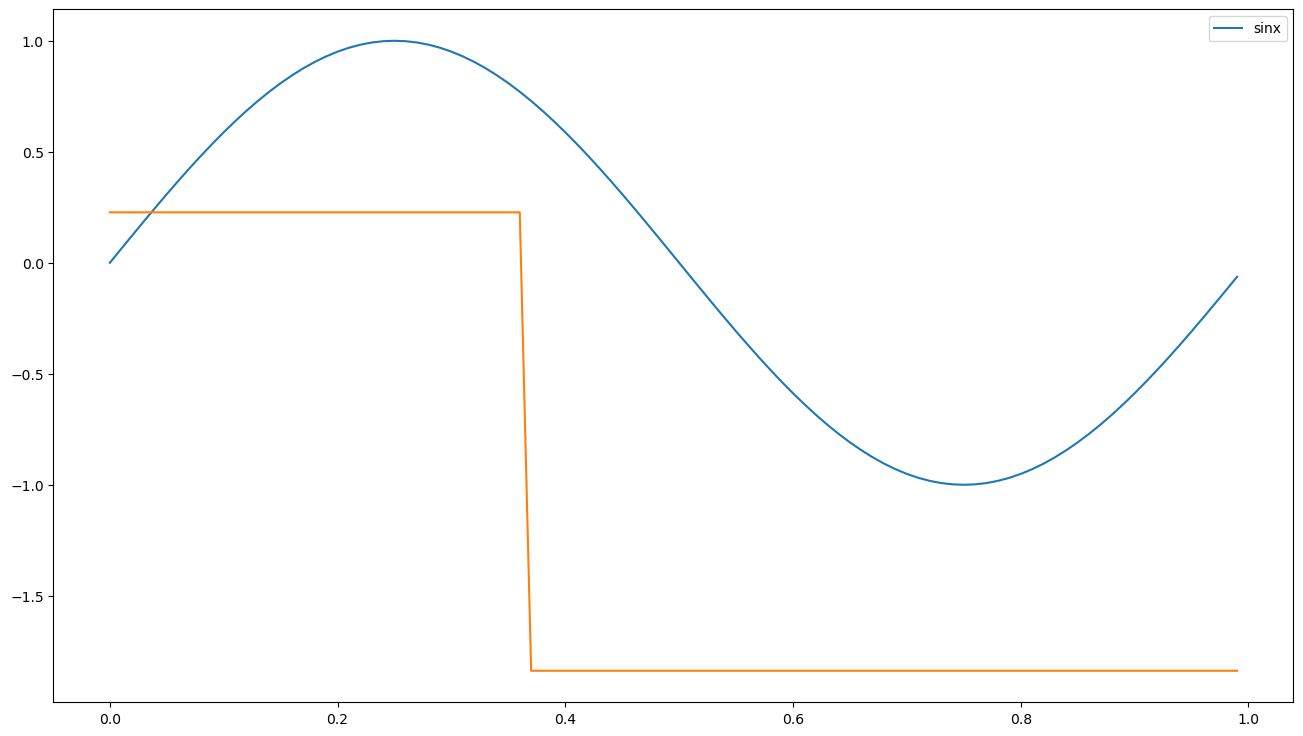

In [ ]:
plt.figure(figsize=(16, 9))
base = np.arange(0, 1.0, 0.01, dtype = np.float32)
with torch.no_grad():
    base_tensor = torch.tensor(base[:, np.newaxis])
    final_output = final_model.forward(base_tensor)
plt.plot(base, np.sin(base * 2 * np.pi), label = "sinx")
plt.plot(base, final_output)
plt.legend()